In [8]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as skp
from load_data import *
import torch

In [9]:
def LinearRegressionRidge(X, Y,K,lambdas,CV): 
    
    
    D_error=np.empty((K,len(lambdas)))
    error=np.empty((len(lambdas)))
    i=0
    for train_index, test_index in CV.split(X,Y):
        j=0
        X_train=X[train_index]
        Y_train=Y[train_index]
        X_test=X[test_index]
        Y_test=Y[test_index]
        for l in lambdas:
            clf = Ridge(alpha=l)
            clf.fit(X_train,Y_train)
            w=clf.coef_
            Y_model=X_test @ w.T
            D_error[i][j]=mean_squared_error(Y_model,Y_test)
            j=j+1
        i=i+1    
    error=np.mean(D_error,axis=0)
    opt_lambda=lambdas[np.argmin(error)]
    return error, opt_lambda

#definition of the function that will do the baseline
def Baseline(X,Y,K,CV):
    
    split_test_error = np.empty(K)
    j=0
    general_error=0
    z_base1=[]
    for train_index, test_index in CV.split(X,Y):
        
        X_train=X[train_index]
        Y_train=Y[train_index]
        X_test=X[test_index]
        Y_test=Y[test_index]
        Y_predict=Y_train.mean()*np.ones(len(Y_test)) 
        z_base1=np.append(z_base1,[(Y_predict-Y_test.T)**2])
        split_test_error[j]=mean_squared_error(Y_predict,Y_test) #calculating test error of (j+1)th split
        general_error=general_error+split_test_error[j]*len(X_test)/len(X) #calculating the general error 
        j=j+1
        
               
    return split_test_error, general_error, z_base1

#function for training neural networks from toolbox_02450

def train_neural_net(model, loss_fn, X, y,n_replicates=3, max_iter = 10000, tolerance=1e-6):
   
    
    
    # Specify maximum number of iterations for training
    logging_frequency = 1000 # display the loss every 1000th iteration
    best_final_loss = 1e100
    for r in range(n_replicates):
        #print('\n\tReplicate: {}/{}'.format(r+1, k))
        # Make a new net (calling model() makes a new initialization of weights) 
        net = model()
        
        # initialize weights based on limits that scale with number of in- and
        # outputs to the layer, increasing the chance that we converge to 
        # a good solution
        torch.nn.init.xavier_uniform_(net[0].weight)
        torch.nn.init.xavier_uniform_(net[2].weight)
                     
        # We can optimize the weights by means of stochastic gradient descent
        # The learning rate, lr, can be adjusted if training doesn't perform as
        # intended try reducing the lr. If the learning curve hasn't converged
        # (i.e. "flattend out"), you can try try increasing the maximum number of
        # iterations, but also potentially increasing the learning rate:
        #optimizer = torch.optim.SGD(net.parameters(), lr = 2e-2)
        
        # A more complicated optimizer is the Adam-algortihm, which is an extension
        # of SGD to adaptively change the learing rate, which is widely used:
        optimizer = torch.optim.Adam(net.parameters())
        
        # Train the network while displaying and storing the loss
        #print('\t\t{}\t{}\t\t\t{}'.format('Iter', 'Loss','Rel. loss'))
        learning_curve = [] # setup storage for loss at each step
        old_loss = 1e6
        for i in range(max_iter):
            y_est = net(X) # forward pass, predict labels on training set
            loss = loss_fn(y_est, y) # determine loss
            loss_value = loss.data.numpy() #get numpy array instead of tensor
            #learning_curve.append(loss_value) # record loss for later display
            
            # Convergence check, see if the percentual loss decrease is within
            # tolerance:
            p_delta_loss = np.abs(loss_value-old_loss)/old_loss
            if p_delta_loss < tolerance: break
            old_loss = loss_value
            
            # display loss with some frequency:
            #if (i != 0) & ((i+1) % logging_frequency == 0):
                #print_str = '\t\t' + str(i+1) + '\t' + str(loss_value) + '\t' + str(p_delta_loss)
                #print(print_str)
            # do backpropagation of loss and optimize weights 
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            
            
        # display final loss
        print('\t\tFinal loss:')
        print_str = '\t\t' + str(i+1) + '\t' + str(loss_value) + '\t' + str(p_delta_loss)
        print(print_str)
        
        if loss_value < best_final_loss: 
            best_net = net
            best_final_loss = loss_value
            #best_learning_curve = learning_curve
        
    # Return the best curve along with its final loss and learing curve
    return best_net, best_final_loss

In [10]:
data = load()

#dividing inputs and output
Y=data['CO2 Emissions'].to_numpy()
X=data.drop('CO2 Emissions',1)
#scaling of the inputs
scaler = skp.StandardScaler()
scaledX = scaler.fit_transform(X)

scaledY=Y-Y.mean()
scaledY=scaledY.reshape(-1,1)

C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Ian\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


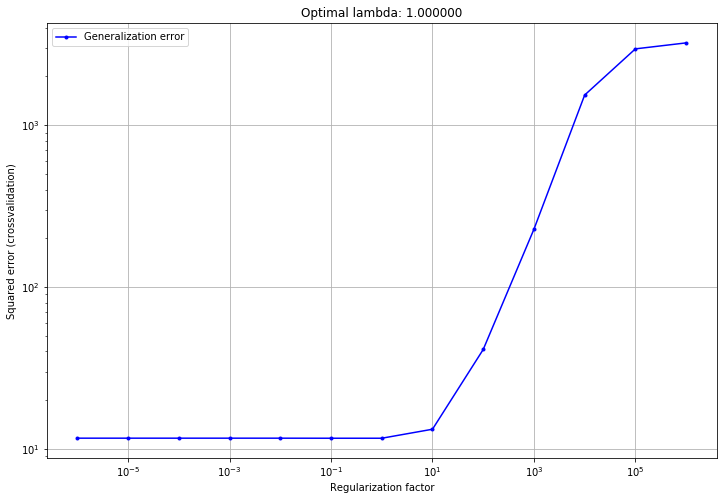

In [11]:
#Regression: part A
import sklearn.linear_model as lm
from sklearn import model_selection
from toolbox_02450 import rlr_validate
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
K=5
lambdas1=np.power(10.,range(-6,7))
CV_A=model_selection.KFold(K,shuffle=True)
    
error, opt_lambda = LinearRegressionRidge(scaledX,scaledY,K, lambdas1,CV_A)
plt.figure(figsize=(12,8))
plt.title('Optimal lambda: %f' %opt_lambda)
plt.loglog(lambdas1,error,'b.-')
plt.xlabel('Regularization factor')
plt.ylabel("Squared error (crossvalidation)")
plt.legend(['Generalization error'])
plt.grid()
##the end of the part A



In [17]:
n_hidden_units = [1,5,10,15,20,25,30]    # number of hidden units
n_replicates = 1        # number of networks trained in each k-fold
max_iter = 15000        # 
K1=5
K2=5
CVo = model_selection.KFold(K1, shuffle=True)
CVi = model_selection.KFold(K2,shuffle=True)
errors_inner=np.empty((K2,len(n_hidden_units)))
errors_mean=np.empty(len(n_hidden_units))
test_errors=np.empty(K1)

opt_n=[0]*K1

#training of the baseline model
baseline_test_error, baseline_generalization_error,z_base=Baseline(scaledX,scaledY,K1,CVo)


#training of the linear regression model

i=0
opt_lambda_array=np.empty(K1) #optimal lambda for each of the CV splits
lambd=np.power(10.,range(-6,7))
ridge_test_error=np.empty(K1)
z_regr=[]
z_ANN=[]
for train_index, test_index in CVo.split(scaledX,scaledY):
    
    X_test=scaledX[test_index]
    X_par=scaledX[train_index]
    Y_test=scaledY[test_index]
    Y_par=scaledY[train_index]
    error_val, opt_lambda = LinearRegressionRidge(X_par,Y_par,K2, lambd,CVi)
    opt_lambda_array[i]=opt_lambda
    
    
    clf = Ridge(alpha=opt_lambda)
    clf.fit(X_par,Y_par)
    w=clf.coef_
    Y_model=X_test @ w.T
    z_regr=np.append(z_regr,[(Y_model-Y_test)**2])
    ridge_test_error[i]=mean_squared_error(Y_model,Y_test)
    i=i+1    
ridge_general_error=ridge_test_error.mean()


#training of the ANN
m=0
for train_index, test_index in CVo.split(scaledX,scaledY): #outer loop
    print('{}. iteration of the outer loop'.format(m+1))
    i=0
    j=0
    X_test=scaledX[test_index]
    X_par=scaledX[train_index]
    Y_test=scaledY[test_index]
    Y_par=scaledY[train_index]
    for train_index, test_index in CVi.split(X_par,Y_par): #inner loop
        l=0
        X_train=torch.tensor(X_par[train_index],dtype=torch.float) #converting to pytorch tensors
        Y_train=torch.tensor(Y_par[train_index],dtype=torch.float)
        X_val=torch.tensor(X_par[test_index],dtype=torch.float)
        Y_val=torch.tensor(Y_par[test_index],dtype=torch.float)
        for n in n_hidden_units: #creating neural nerwork
            
            model = lambda: torch.nn.Sequential(
                    torch.nn.Linear(X_par.shape[1], n), #M features to n_hidden_units
                    torch.nn.Tanh(),   # 1st transfer function,
                    torch.nn.Linear(n, 1), # n_hidden_units to 1 output neuron
                    # no final tranfer function, i.e. "linear output"
                    )
            loss_fn = torch.nn.MSELoss() # notice how this is now a mean-squared-error loss
            print('\n\tReplicate: {}/{}'.format(i+1, K2))
            print('\n\t h={}'.format(n))

            net, final_loss= train_neural_net(model,
                                                       loss_fn,
                                                       X=X_train,
                                                       y=Y_train,
                                                       n_replicates=1,
                                                       max_iter=max_iter)
            y_val_est = net(X_val)
    
            # Determine errors and errors
            se = (y_val_est.float()-Y_val.float())**2 # squared error
            errors_inner[j][l] = (sum(se).type(torch.float)/len(Y_val)).data.numpy() #mean
            print('Individual error in inner loop for h=',n,'and for iteration K2=',j+1,'is',errors_inner[j][l])
            l=l+1
        i=i+1
        j=j+1
   
    errors_mean=np.mean(errors_inner,axis=0)
    opt_n[m]=n_hidden_units[np.argmin(errors_mean)]
    print('Mean errors are',errors_mean)
    XtestTensor=torch.tensor(X_test,dtype=torch.float)
    XparTensor=torch.tensor(X_par,dtype=torch.float)
    YtestTensor=torch.tensor(Y_test,dtype=torch.float)
    YparTensor=torch.tensor(Y_par,dtype=torch.float)
    #training the optimal model
    model1 = lambda: torch.nn.Sequential(
                    torch.nn.Linear(X_par.shape[1], opt_n[m]), #M features to n_hidden_units
                    torch.nn.Tanh(),   # 1st transfer function,
                    torch.nn.Linear(opt_n[m], 1), # n_hidden_units to 1 output neuron
                    # no final tranfer function, i.e. "linear output"
                    )
    loss_fn1 = torch.nn.MSELoss() # notice how this is now a mean-squared-error loss
    print('Optimal model with the optimal n being:{}'.format(opt_n[m]))
    

    net1, final_loss= train_neural_net(model1,loss_fn1,X=XparTensor, y=YparTensor, n_replicates=1, max_iter=max_iter)
    y_val_est1 = net1(XtestTensor)
    square_error_outer = (y_val_est1.float()-YtestTensor.float())**2 # squared error
    z_ANN=np.append(z_ANN,[square_error_outer.data.numpy()])
    test_errors[m] = (sum(square_error_outer).type(torch.float)/len(YtestTensor)).data.numpy() #mean
    m=m+1

print('Baseline test error is',baseline_test_error)    
print('Ridge test errors are',ridge_test_error,'and values for optimal lambda are:',opt_lambda_array)
print('Individual test errors are:',test_errors,' and optimal values of h are:',opt_n)




1. iteration of the outer loop

	Replicate: 1/5

	 h=1
		Final loss:
		15000	2107.1533	2.8733142e-05
Individual error in inner loop for h= 1 and for iteration K2= 1 is 2131.0283203125

	Replicate: 1/5

	 h=5
		Final loss:
		15000	372.2882	0.00013154934
Individual error in inner loop for h= 5 and for iteration K2= 1 is 261.3359069824219

	Replicate: 1/5

	 h=10
		Final loss:
		15000	95.00132	0.00022304669
Individual error in inner loop for h= 10 and for iteration K2= 1 is 22.781930923461914

	Replicate: 1/5

	 h=15
		Final loss:
		15000	30.26458	0.00031589487
Individual error in inner loop for h= 15 and for iteration K2= 1 is 3.644876718521118

	Replicate: 1/5

	 h=20
		Final loss:
		15000	10.251587	0.0005002349
Individual error in inner loop for h= 20 and for iteration K2= 1 is 4.350505828857422

	Replicate: 1/5

	 h=25
		Final loss:
		15000	3.2602255	0.0004960835
Individual error in inner loop for h= 25 and for iteration K2= 1 is 6.40077018737793

	Replicate: 1/5

	 h=30
		Final loss:

		15000	15.796579	0.00028958195
Individual error in inner loop for h= 15 and for iteration K2= 5 is 90.21087646484375

	Replicate: 5/5

	 h=20
		Final loss:
		15000	5.7562814	0.00047435213
Individual error in inner loop for h= 20 and for iteration K2= 5 is 51.148155212402344

	Replicate: 5/5

	 h=25
		Final loss:
		15000	2.4913318	0.0004796059
Individual error in inner loop for h= 25 and for iteration K2= 5 is 38.9844856262207

	Replicate: 5/5

	 h=30
		Final loss:
		15000	1.5033382	0.00029727304
Individual error in inner loop for h= 30 and for iteration K2= 5 is 35.37062454223633
Mean errors are [1996.44458008  342.90678101   75.84404697   34.2250217    19.40539937
   15.46237402   14.23841572]
Optimal model with the optimal n being:30
		Final loss:
		15000	2.3271441	0.00039274583
4. iteration of the outer loop

	Replicate: 1/5

	 h=1
		Final loss:
		15000	2142.7332	2.8711775e-05
Individual error in inner loop for h= 1 and for iteration K2= 1 is 1434.8760986328125

	Replicate: 1/5

	 

In [18]:
#t-test, confidence interval and p-value
import scipy.stats as st

#1.Linear regression vs Baseline
alpha=0.05
z1 = z_regr - z_base
CI1 = st.t.interval(1-alpha, len(z1)-1, loc=np.mean(z1), scale=st.sem(z1))  # Confidence interval
p1 = st.t.cdf( -np.abs( np.mean(z1) )/st.sem(z1), df=len(z1)-1)  # p-value
print('Confidence interval is',CI1,'and p-value is',p1)

#2.Linear regression vs ANN
z2 = z_regr - z_ANN
CI2 = st.t.interval(1-alpha, len(z2)-1, loc=np.mean(z2), scale=st.sem(z2))  # Confidence interval
p2 = st.t.cdf( -np.abs( np.mean(z2) )/st.sem(z2), df=len(z2)-1)  # p-value
print('Confidence interval is',CI2,'and p-value is',p2)

#3. ANN vs baseline
z3 = z_ANN - z_base
CI3 = st.t.interval(1-alpha, len(z3)-1, loc=np.mean(z3), scale=st.sem(z3))  # Confidence interval
p3 = st.t.cdf( -np.abs( np.mean(z3) )/st.sem(z3), df=len(z3)-1)  # p-value
print('Confidence interval is',CI3,'and p-value is',p3)


Confidence interval is (-3581.496357549624, -2918.3047477487) and p-value is 6.961208047747079e-71
Confidence interval is (-6.716466144875399, 10.568174968954674) and p-value is 0.3310015915771086
Confidence interval is (-3583.4720792981097, -2920.1807348242937) and p-value is 6.171694947256586e-71
